In [1]:
import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datlib.FRED import *
from datlib.plots import *
import pandas_datareader.data as web

%matplotlib inline

# Import Statsmodels

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
#FRED.py
#. . . 
def bil_to_mil(series):
    return series* 10**3
# . . .
#fedProject.py
# . . .
data_codes  = {# Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Capital
               "Balance Sheet: Total Capital": "WCTCL",
               # Interest Rates
               "Unemployment Rate": "UNRATE",
               "Nominal GDP ($ Bil)":"GDP",
               "Real GDP ($ Bil)":"GDPC1",
               "GDP Deflator":"GDPDEF",
               "CPI":"CPIAUCSL",
               "Core PCE":"PCEPILFE",
               "Private Investment":"GPDI",
               "Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Bil)": "WCURCIR",
               "1 Month Treasury Rate (%)": "DGS1MO",
               "3 Month Treasury Rate (%)": "DGS3MO",               
               "1 Year Treasury Rate (%)": "DGS1",
               "2 Year Treasury Rate (%)": "DGS2",
               "10 Year Treasury Rate (%)": "DGS10",
               "30 Year Treasury Rate (%)": "DGS30",               
               "Effective Federal Funds Rate (%)": "DFF",
               "Federal Funds Target Rate (Pre-crisis)":"DFEDTAR",
               "Federal Funds Upper Target":"DFEDTARU",
               "Federal Funds Lower Target":"DFEDTARL",
               "Interest on Reserves (%)": "IOER",
               "VIX": "VIXCLS",
                "5 Year Forward Rate": "T5YIFR"
               }

inflation_target = 2

unemployment_target = 4
# Select start and end dates
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

## year variable automatically adjusts the numper of periods  
#   per year in light of data frequency
annual_div = {"Q":4,
             "W":52,
             "M":12}
### choose frequency
freq = "M"
### set periods per year
year = annual_div[freq]


In [3]:
#data cleaning, importing

d_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')
df = pd.read_csv('M4-3.csv', parse_dates=['Date'], date_parser=d_parser)
df

C:\Users\HP\AppData\Local\Temp/ipykernel_6988/1110085206.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  d_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')


,Date,M4,Log Total Assets,Effective Federal Funds Rate (%),Log Currency in Circulation ($ Bil),Unemployment Rate,Inflation Rate
0,2010-01-31,7.07,14.63,0.11,6.83,9.8,2.62
1,2010-02-28,7.06,14.63,0.13,6.83,9.8,2.15
2,2010-03-31,7.05,14.65,0.17,6.84,9.9,2.29
3,2010-04-30,7.06,14.66,0.20,6.84,9.9,2.21
4,2010-05-31,7.06,14.66,0.20,6.84,9.6,2.00
...,...,...,...,...,...,...,...
115,2019-08-31,7.40,15.14,2.13,7.47,3.7,1.74
116,2019-09-30,7.40,15.15,2.04,7.47,3.5,1.72
117,2019-10-31,7.41,15.19,1.83,7.48,3.6,1.77
118,2019-11-30,7.42,15.21,1.55,7.49,3.6,2.04


In [4]:
df['Date_at_year_month'] = df['Date'].dt.strftime('%Y-%m')

In [5]:
column_names = {'Date_at_year_month':'DATE',
                'M4':'M4',
                'Log Total Assets': 'TA',
                'Log Currency in Circulation ($ Bil)':'CC',
                'Effective Federal Funds Rate (%)':'FFR',
               'Unemployment Rate': 'U',
               'Inflation Rate': 'I'}

# rename columns
df = df.rename(columns = column_names)

df

,Date,M4,TA,FFR,CC,U,I,DATE
0,2010-01-31,7.07,14.63,0.11,6.83,9.8,2.62,2010-01
1,2010-02-28,7.06,14.63,0.13,6.83,9.8,2.15,2010-02
2,2010-03-31,7.05,14.65,0.17,6.84,9.9,2.29,2010-03
3,2010-04-30,7.06,14.66,0.20,6.84,9.9,2.21,2010-04
4,2010-05-31,7.06,14.66,0.20,6.84,9.6,2.00,2010-05
...,...,...,...,...,...,...,...,...
115,2019-08-31,7.40,15.14,2.13,7.47,3.7,1.74,2019-08
116,2019-09-30,7.40,15.15,2.04,7.47,3.5,1.72,2019-09
117,2019-10-31,7.41,15.19,1.83,7.48,3.6,1.77,2019-10
118,2019-11-30,7.42,15.21,1.55,7.49,3.6,2.04,2019-11


In [6]:
df = df.set_index('DATE')
df

,Date,M4,TA,FFR,CC,U,I
DATE,,,,,,,
2010-01,2010-01-31,7.07,14.63,0.11,6.83,9.8,2.62
2010-02,2010-02-28,7.06,14.63,0.13,6.83,9.8,2.15
2010-03,2010-03-31,7.05,14.65,0.17,6.84,9.9,2.29
2010-04,2010-04-30,7.06,14.66,0.20,6.84,9.9,2.21
2010-05,2010-05-31,7.06,14.66,0.20,6.84,9.6,2.00
...,...,...,...,...,...,...,...
2019-08,2019-08-31,7.40,15.14,2.13,7.47,3.7,1.74
2019-09,2019-09-30,7.40,15.15,2.04,7.47,3.5,1.72
2019-10,2019-10-31,7.41,15.19,1.83,7.48,3.6,1.77


In [7]:
df = df.drop(['Date'], axis = 1)
df

,M4,TA,FFR,CC,U,I
DATE,,,,,,
2010-01,7.07,14.63,0.11,6.83,9.8,2.62
2010-02,7.06,14.63,0.13,6.83,9.8,2.15
2010-03,7.05,14.65,0.17,6.84,9.9,2.29
2010-04,7.06,14.66,0.20,6.84,9.9,2.21
2010-05,7.06,14.66,0.20,6.84,9.6,2.00
...,...,...,...,...,...,...
2019-08,7.40,15.14,2.13,7.47,3.7,1.74
2019-09,7.40,15.15,2.04,7.47,3.5,1.72
2019-10,7.41,15.19,1.83,7.48,3.6,1.77


In [8]:
data = df
data

,M4,TA,FFR,CC,U,I
DATE,,,,,,
2010-01,7.07,14.63,0.11,6.83,9.8,2.62
2010-02,7.06,14.63,0.13,6.83,9.8,2.15
2010-03,7.05,14.65,0.17,6.84,9.9,2.29
2010-04,7.06,14.66,0.20,6.84,9.9,2.21
2010-05,7.06,14.66,0.20,6.84,9.6,2.00
...,...,...,...,...,...,...
2019-08,7.40,15.14,2.13,7.47,3.7,1.74
2019-09,7.40,15.15,2.04,7.47,3.5,1.72
2019-10,7.41,15.19,1.83,7.48,3.6,1.77


In [9]:
data.isnull().sum()

M4     0
TA     0
FFR    0
CC     0
U      0
I      0
dtype: int64

In [10]:
## 1st diff
data_diff = data.diff().dropna()
data_diff

,M4,TA,FFR,CC,U,I
DATE,,,,,,
2010-02,-0.01,0.00,0.02,0.00,0.0,-0.47
2010-03,-0.01,0.02,0.04,0.01,0.1,0.14
2010-04,0.01,0.01,0.03,0.00,0.0,-0.08
2010-05,0.00,0.00,0.00,0.00,-0.3,-0.21
2010-06,-0.01,0.01,-0.02,0.01,-0.2,-0.88
...,...,...,...,...,...,...
2019-08,0.01,-0.01,-0.27,0.00,0.1,-0.08
2019-09,0.00,0.01,-0.09,0.00,-0.2,-0.02
2019-10,0.01,0.04,-0.21,0.01,0.1,0.05


In [11]:
#ADF test

X = data_diff["M4"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_diff["FFR"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_diff["TA"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_diff["CC"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_diff["U"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
X = data_diff["I"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -15.211102
p-value: 0.000000
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580
Reject Ho - Time Series is Stationary
ADF Statistic: -1.657520
p-value: 0.453122
Critical Values:
	1%: -3.492
	5%: -2.889
	10%: -2.581
Failed to Reject Ho - Time Series is Non-Stationary
ADF Statistic: -2.732047
p-value: 0.068655
Critical Values:
	1%: -3.490
	5%: -2.888
	10%: -2.581
Failed to Reject Ho - Time Series is Non-Stationary
ADF Statistic: -5.133268
p-value: 0.000012
Critical Values:
	1%: -3.490
	5%: -2.888
	10%: -2.581
Reject Ho - Time Series is Stationary
ADF Statistic: -1.758765
p-value: 0.401117
Critical Values:
	1%: -3.492
	5%: -2.889
	10%: -2.581
Failed to Reject Ho - Time Series is Non-Stationary
ADF Statistic: -4.729846
p-value: 0.000074
Critical Values:
	1%: -3.493
	5%: -2.889
	10%: -2.581
Reject Ho - Time Series is Stationary


In [12]:
##2nd diff
data_new = data_diff.diff().dropna()
data_new

,M4,TA,FFR,CC,U,I
DATE,,,,,,
2010-03,8.881784e-16,2.000000e-02,0.02,1.000000e-02,0.1,0.61
2010-04,2.000000e-02,-1.000000e-02,-0.01,-1.000000e-02,-0.1,-0.22
2010-05,-1.000000e-02,-1.000000e-02,-0.03,0.000000e+00,-0.3,-0.13
2010-06,-1.000000e-02,1.000000e-02,-0.02,1.000000e-02,0.1,-0.67
2010-07,2.000000e-02,-2.000000e-02,0.02,-1.000000e-02,0.2,1.10
...,...,...,...,...,...,...
2019-08,1.000000e-02,0.000000e+00,-0.29,-1.000000e-02,0.1,-0.20
2019-09,-1.000000e-02,2.000000e-02,0.18,0.000000e+00,-0.3,0.06
2019-10,1.000000e-02,3.000000e-02,-0.12,1.000000e-02,0.3,0.07


In [13]:
#ADF test

X = data_new["M4"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["FFR"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["TA"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["CC"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["U"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
X = data_new["I"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -8.381034
p-value: 0.000000
Critical Values:
	1%: -3.491
	5%: -2.888
	10%: -2.581
Reject Ho - Time Series is Stationary
ADF Statistic: -3.943879
p-value: 0.001735
Critical Values:
	1%: -3.492
	5%: -2.889
	10%: -2.581
Reject Ho - Time Series is Stationary
ADF Statistic: -6.016185
p-value: 0.000000
Critical Values:
	1%: -3.490
	5%: -2.887
	10%: -2.581
Reject Ho - Time Series is Stationary
ADF Statistic: -6.497273
p-value: 0.000000
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582
Reject Ho - Time Series is Stationary
ADF Statistic: -7.922465
p-value: 0.000000
Critical Values:
	1%: -3.492
	5%: -2.889
	10%: -2.581
Reject Ho - Time Series is Stationary
ADF Statistic: -4.617794
p-value: 0.000120
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582
Reject Ho - Time Series is Stationary


In [14]:
## Partial Correlation

import statsmodels.api as sm

residuals = {}
for y_var in df.keys():
    X_vars = list(df.keys())
    X_vars.remove(y_var)
    X = df[X_vars]
    # Initial estimate should include constant
    #   This won't be the case we regress the errors
    X["Constant"] = 1
    # pass y_var as list for consistent structure
    y = df[[y_var]]
    model = sm.OLS(y, X)
    results = model.fit()
    residuals[y_var] = results.resid
residuals = pd.DataFrame(residuals)
residuals

,M4,TA,FFR,CC,U,I
DATE,,,,,,
2010-01,0.028805,0.021011,-0.095218,-0.038911,-0.233974,0.653826
2010-02,0.018289,0.009285,0.007696,-0.028268,-0.192946,0.135538
2010-03,0.004676,0.015828,0.135208,-0.007922,0.005185,-0.110117
2010-04,0.015403,0.050207,0.159963,-0.017603,0.046161,-0.217561
2010-05,0.014376,0.012834,0.119665,-0.028901,-0.233021,0.029664
...,...,...,...,...,...,...
2019-08,0.006053,-0.037344,-0.165353,0.005289,0.070490,-0.423017
2019-09,0.007440,-0.065067,-0.264839,-0.003043,-0.119374,-0.078433
2019-10,0.018458,-0.029945,-0.404117,-0.000360,0.110977,-0.168943


In [15]:
residuals.corr()[residuals.corr().abs() < 1].mul(-1).fillna(1).round(2)

,M4,TA,FFR,CC,U,I
M4,1.00,-0.46,0.20,0.72,-0.05,-0.04
TA,-0.46,1.00,-0.60,0.31,-0.52,0.18
FFR,0.20,-0.60,1.00,0.10,-0.17,0.30
CC,0.72,0.31,0.10,1.00,-0.55,0.21
U,-0.05,-0.52,-0.17,-0.55,1.00,0.39
I,-0.04,0.18,0.30,0.21,0.39,1.00


In [16]:
# !pip install pingouin
import pingouin
df.pcorr().round(2)

,M4,TA,FFR,CC,U,I
M4,1.00,-0.46,0.20,0.72,-0.05,-0.04
TA,-0.46,1.00,-0.60,0.31,-0.52,0.18
FFR,0.20,-0.60,1.00,0.10,-0.17,0.30
CC,0.72,0.31,0.10,1.00,-0.55,0.21
U,-0.05,-0.52,-0.17,-0.55,1.00,0.39
I,-0.04,0.18,0.30,0.21,0.39,1.00


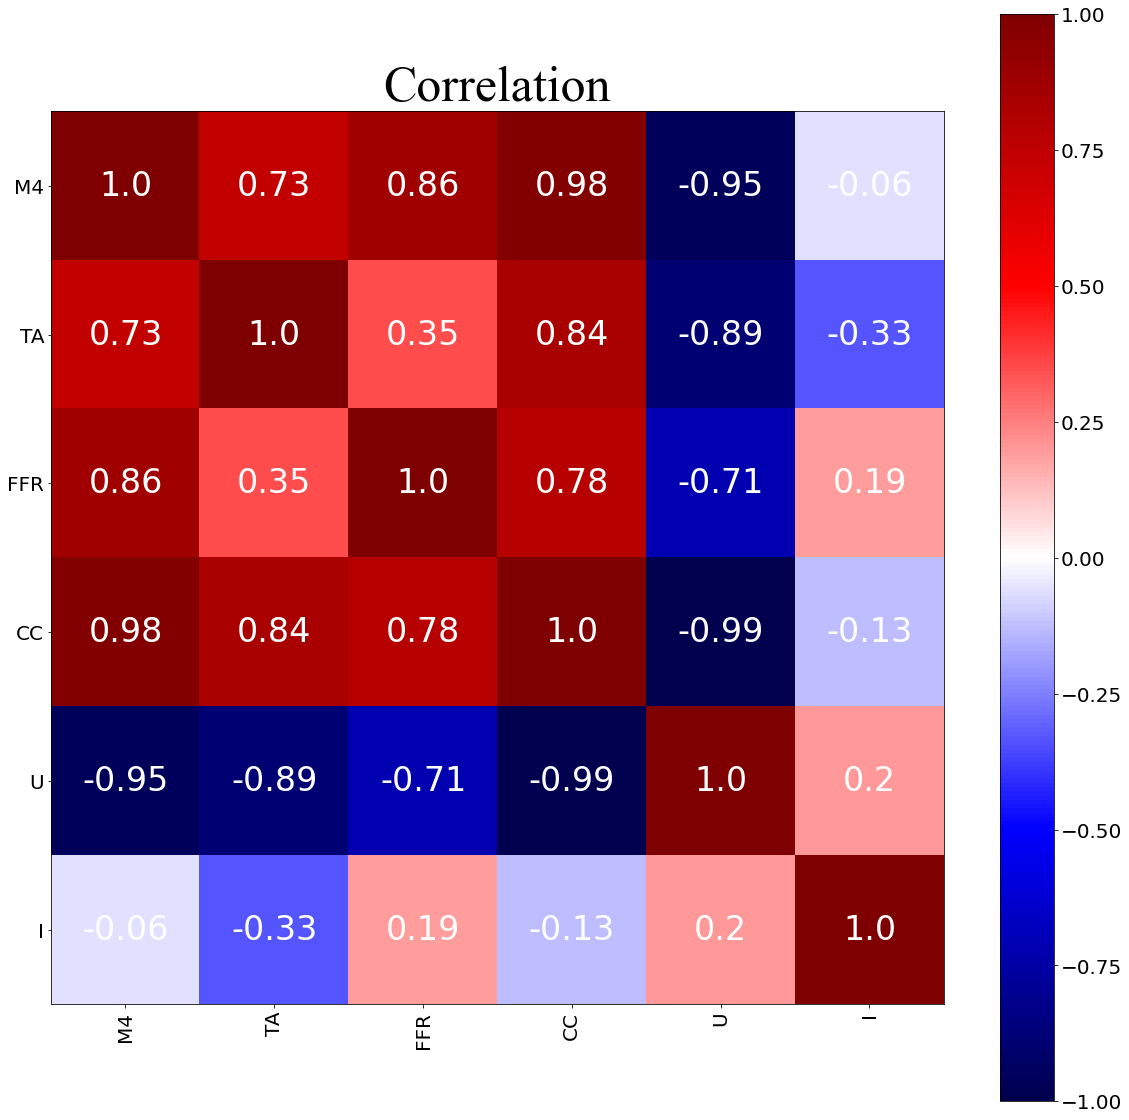

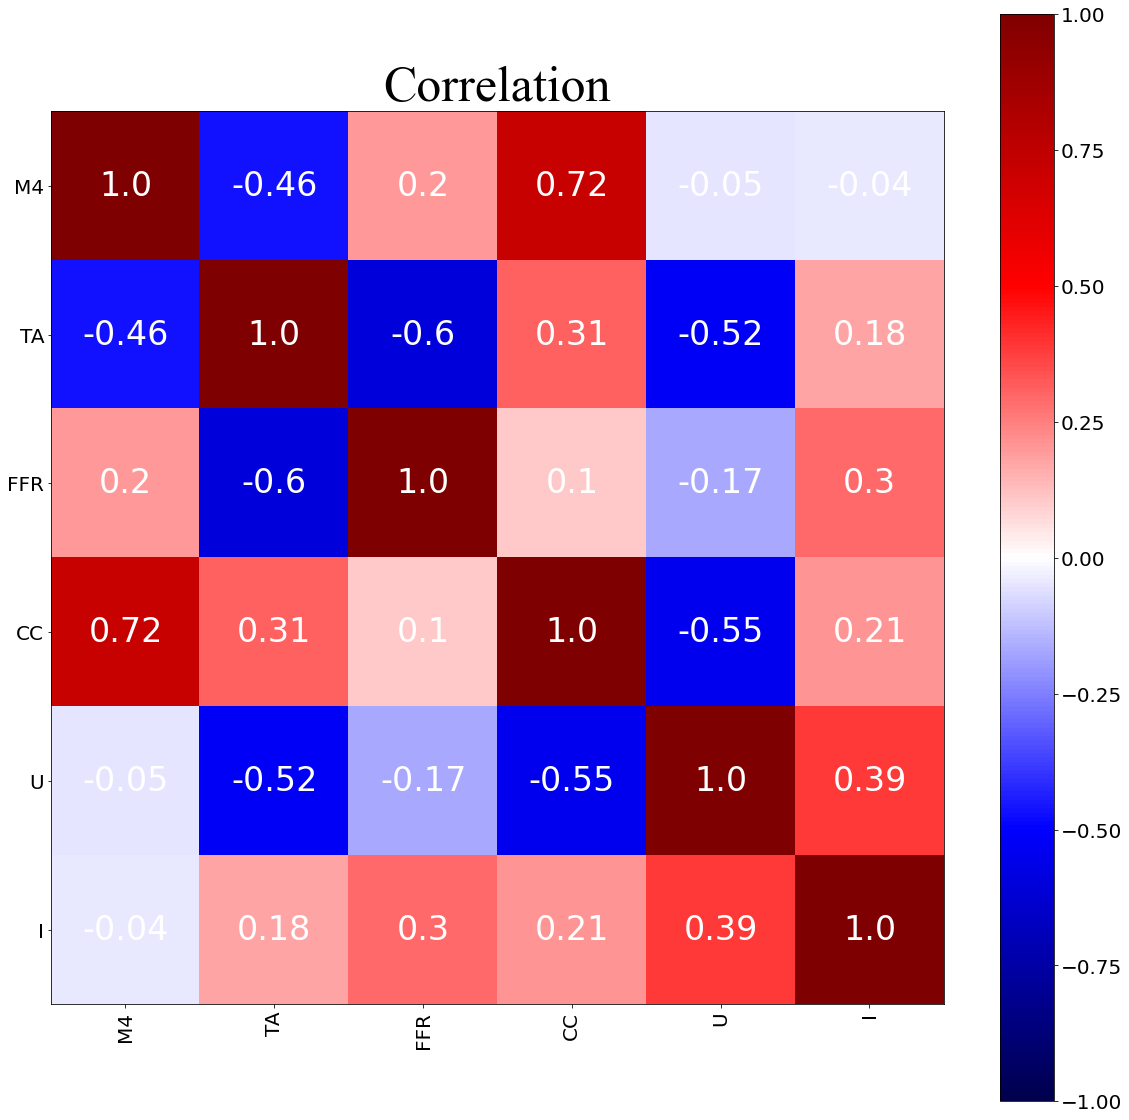

In [17]:
from datlib.plots import *
corr_matrix_heatmap(df.corr(), 
                    save_fig = False, 
                    pp = None)
corr_matrix_heatmap(df.pcorr(), save_fig = False, pp = None)

In [18]:
pcorr_pvalues = {}
for y, Y in residuals.items():
    pcorr_pvalues[y] = {}
    for x, X in residuals.items():
        if x != y:
            pcorr_pvalues[y][x] = sm.OLS(Y,X).fit().pvalues[x]
        
        else:
            pcorr_pvalues[y][x] = np.NaN
pd.DataFrame(pcorr_pvalues).round(2)

,M4,TA,FFR,CC,U,I
M4,NaN,0.00,0.03,0.00,0.59,0.63
TA,0.00,NaN,0.00,0.00,0.00,0.05
FFR,0.03,0.00,NaN,0.26,0.07,0.00
CC,0.00,0.00,0.26,NaN,0.00,0.02
U,0.59,0.00,0.07,0.00,NaN,0.00
I,0.63,0.05,0.00,0.02,0.00,NaN


In [19]:
##DAG

import pingouin
from pgmpy.estimators import PC
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
from networkx.drawing.nx_agraph import graphviz_layout
import warnings
warnings.filterwarnings("ignore")
from matplotlib.backends.backend_pdf import PdfPages
import networkx as nx

In [20]:
## Estimating a Directed Acyclic Graph
p_val = .01
from pgmpy.estimators import PC
c = PC(df)
max_cond_vars = len(df.keys())-2


model = c.estimate(return_type = "dag",variant= "parallel",#"orig", "stable"
                   significance_level = p_val, 
                   max_cond_vars = max_cond_vars, ci_test = "pearsonr")
edges = model.edges()

  0%|          | 0/4 [00:00<?, ?it/s]

OutEdgeView([('TA', 'M4'), ('U', 'FFR'), ('CC', 'FFR'), ('CC', 'U')])

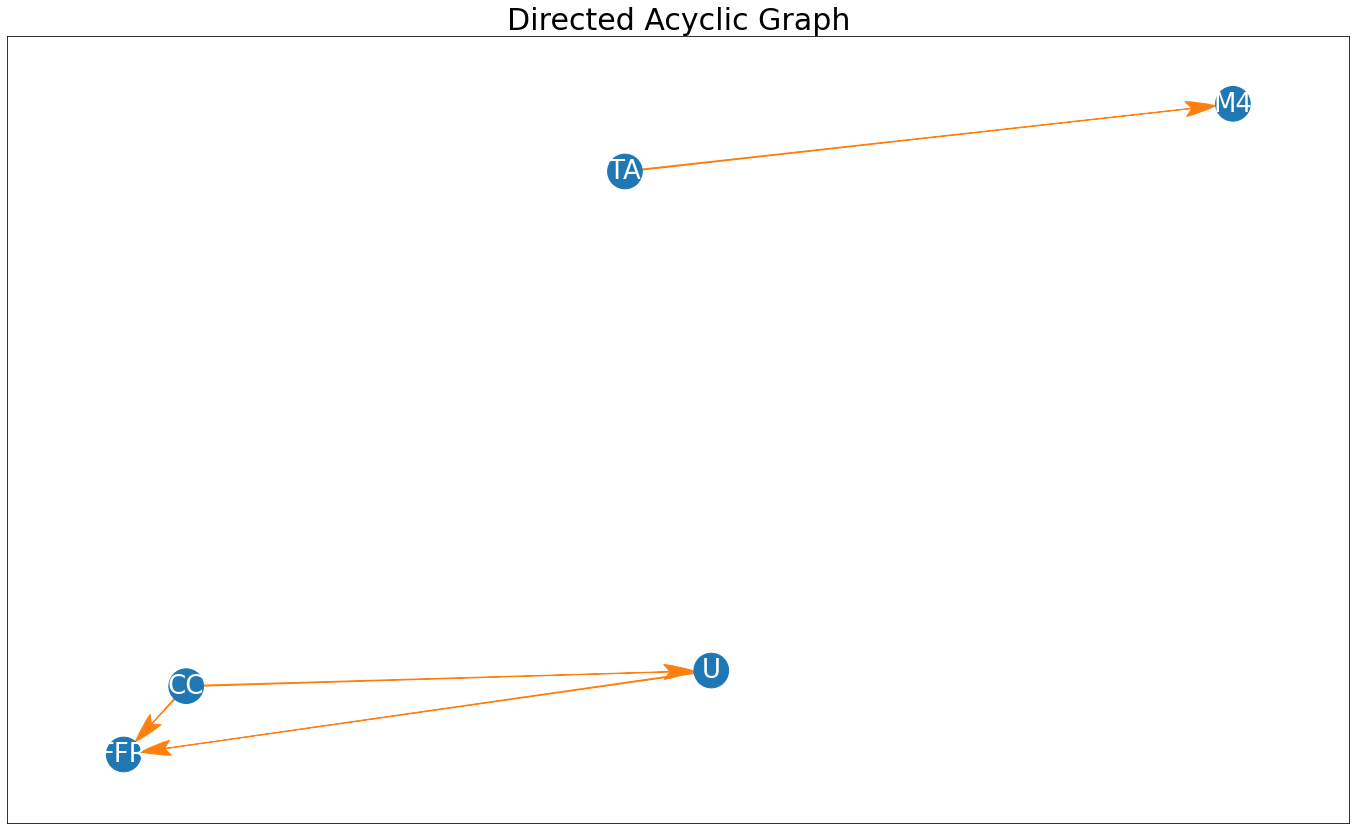

In [21]:
from matplotlib.patches import ArrowStyle

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)

graph_DAG(edges, df, title = "Directed Acyclic Graph")
edges

('TA', 'M4') []
keep control: CC
('U', 'FFR') ['CC']
keep control: U
('CC', 'FFR') ['U']
('CC', 'U') []


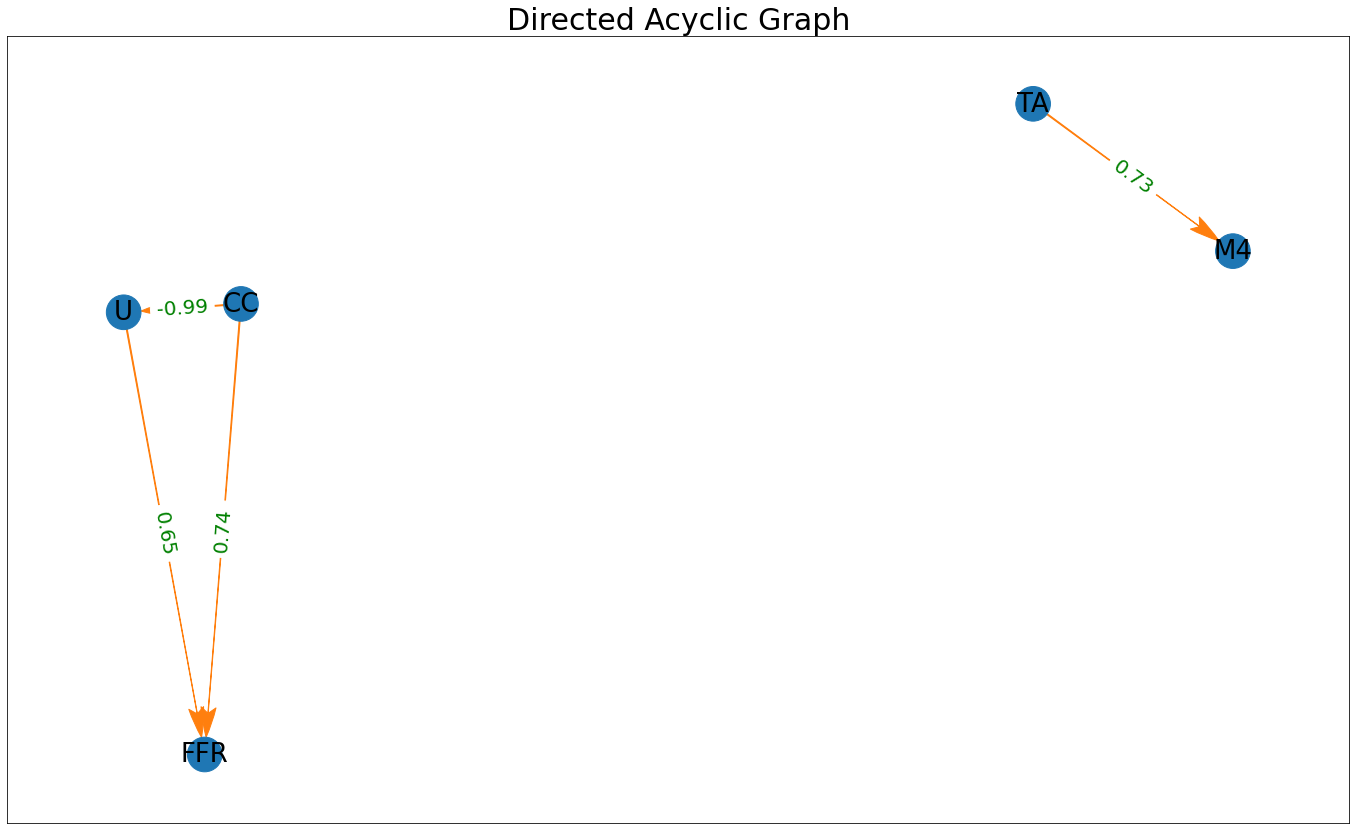

In [22]:
## D-separation

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    edge_labels = {}
    ############ Add ############
    for edge in edges:
        controls = [key for key in df.keys() if key not in edge]
        controls = list(set(controls))
        keep_controls = []
        for control in controls:
            control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
            if (control, edge[1]) in control_edges:
                print("keep control:", control)
                keep_controls.append(control)                
        print(edge, keep_controls)
        pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#         corr_matrix_heatmap(pcorr, save_fig = False, pp = None, title = "Partial Correlation")
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     # turn text black for larger variable names in homework
                     font_color = "k",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    ############ Add ############
    nx.draw_networkx_edge_labels(graph,pos,
                                edge_labels=edge_labels,
                                font_color='green',
                                font_size=20)

graph_DAG(edges, df, title = "Directed Acyclic Graph")

In [23]:
data = df
def firstLetterWord(str, num_chars = 3):
 
    result = ""
 
    # Traverse the string.
    v = True
    for i in range(len(str)):
         
        # If it is space, set v as true.
        if (str[i] == ' '):
            v = True
 
        # Else check if v is true or not.
        # If true, copy character in output
        # string and set v as false.
        elif (str[i] != ' ' and v == True):
            result += (str[i:i+num_chars])
            v = False
 
    return result

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

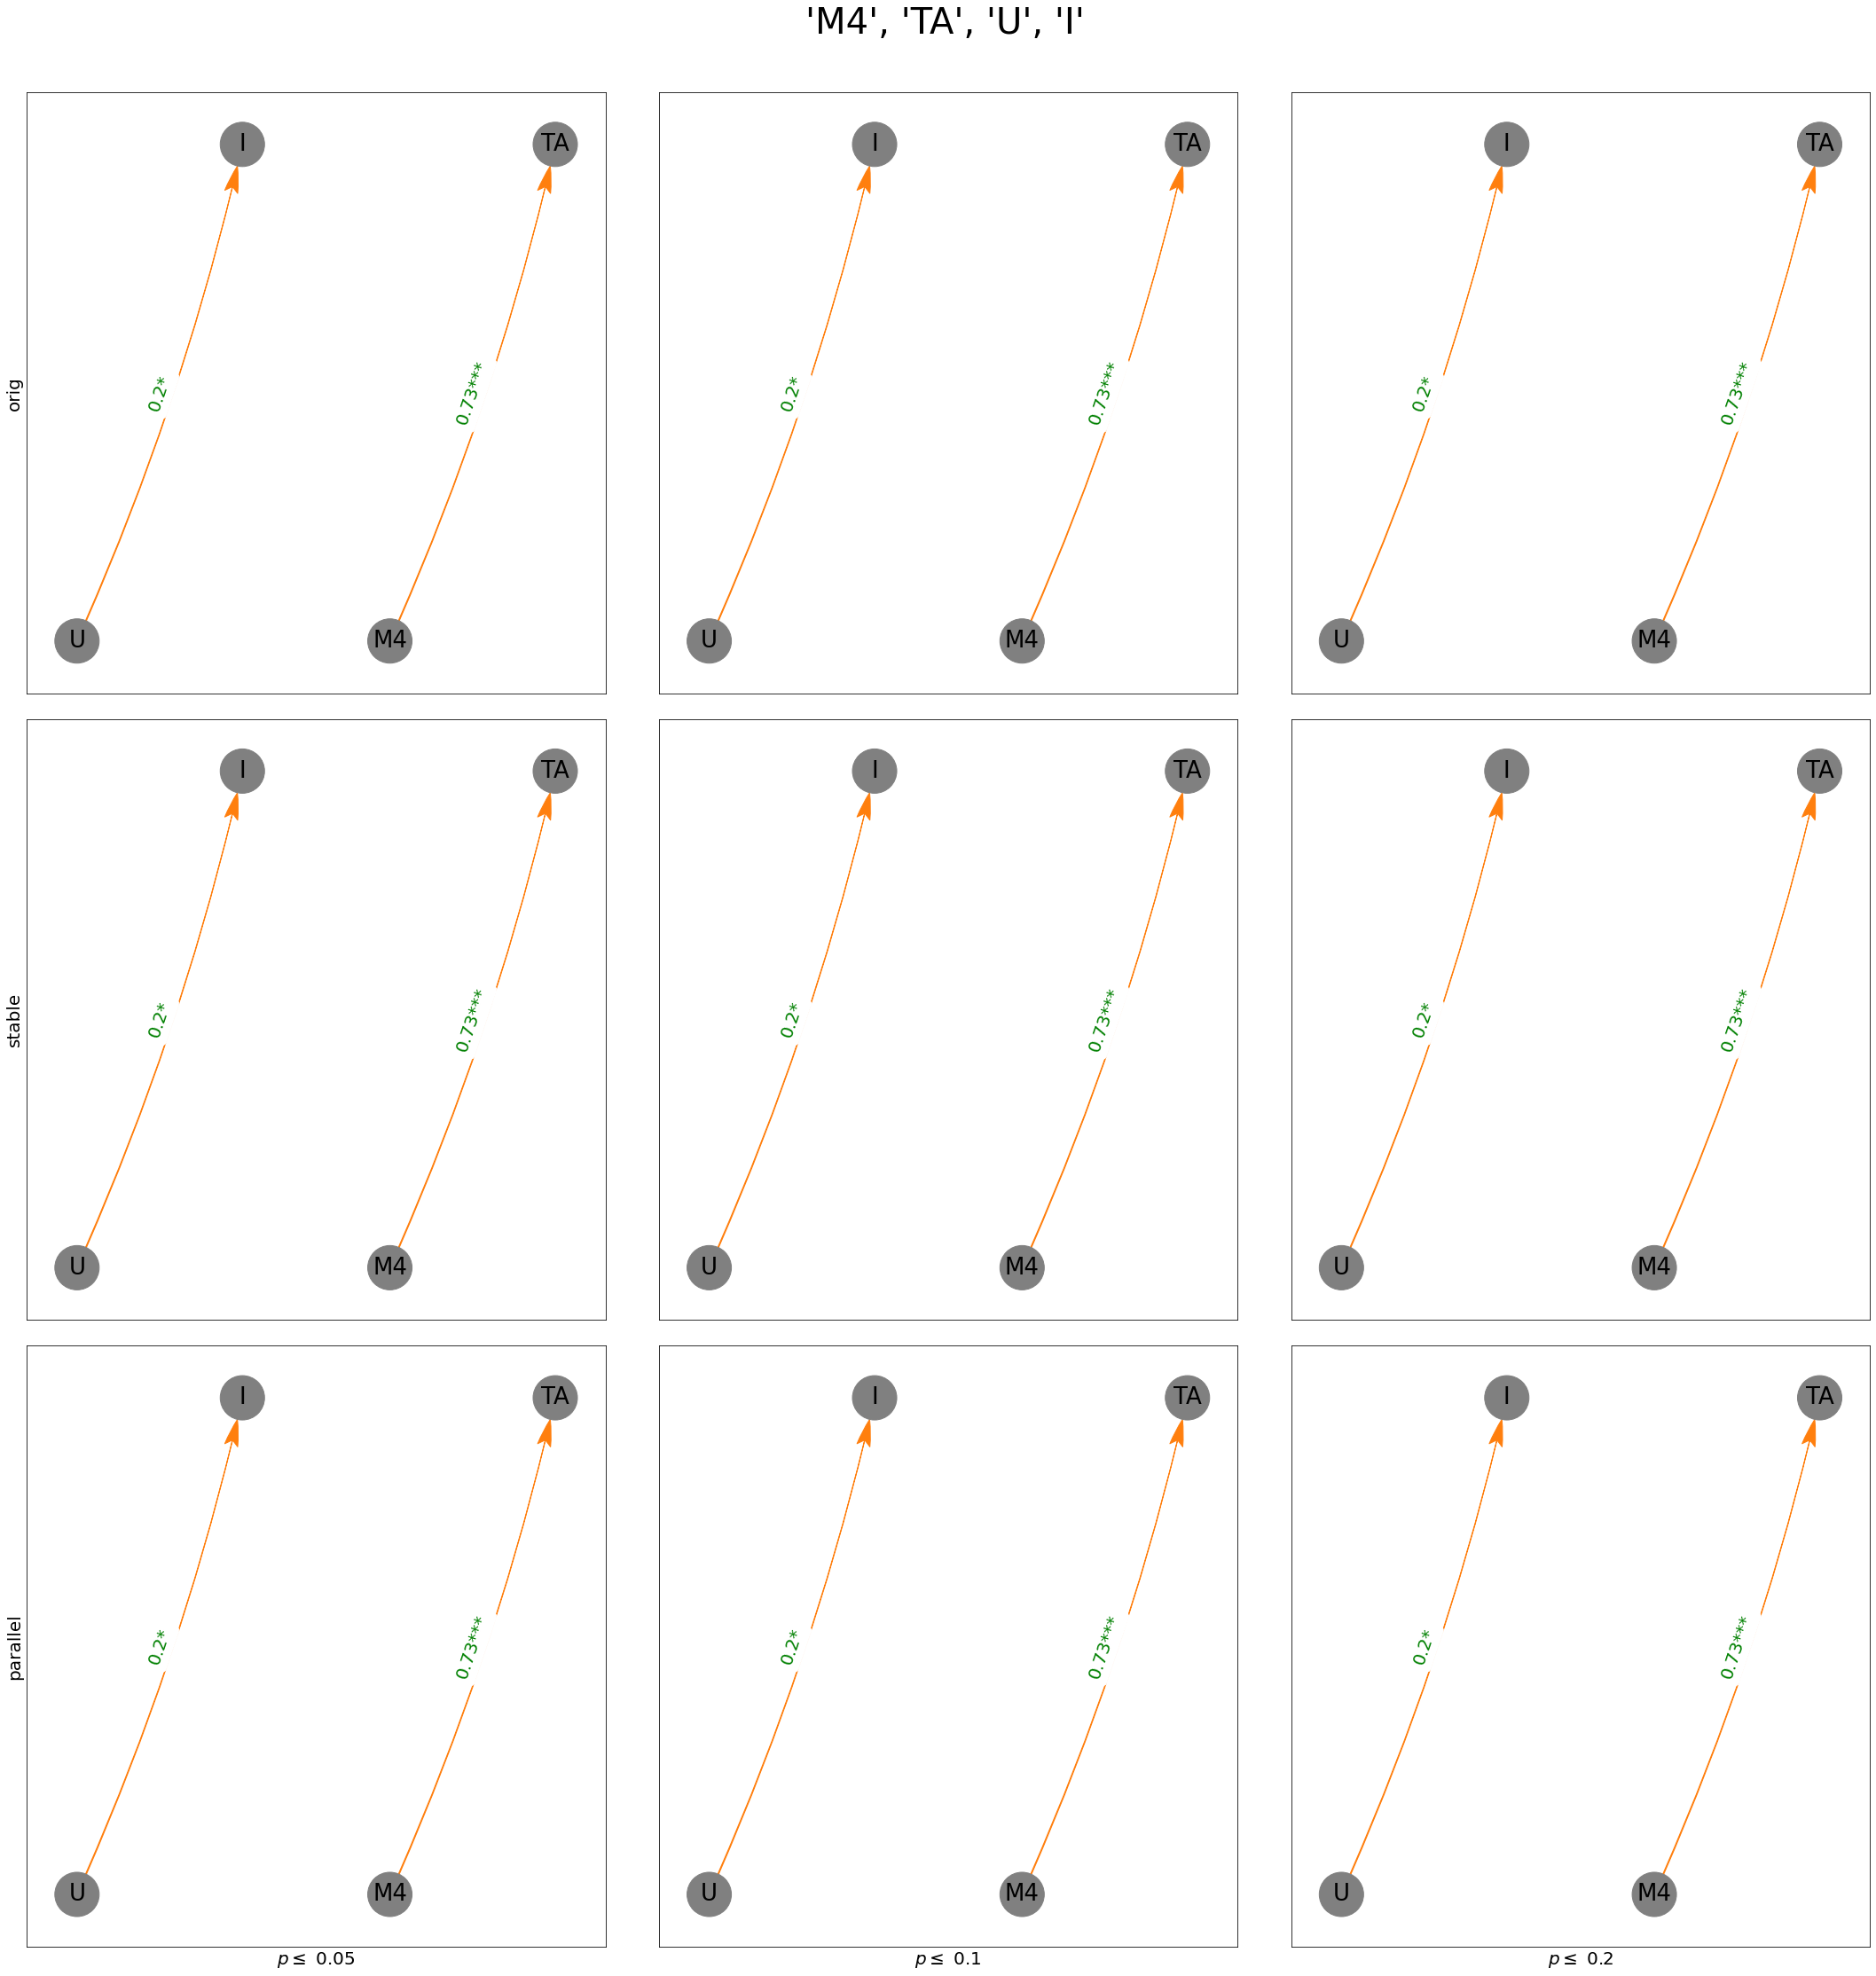

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

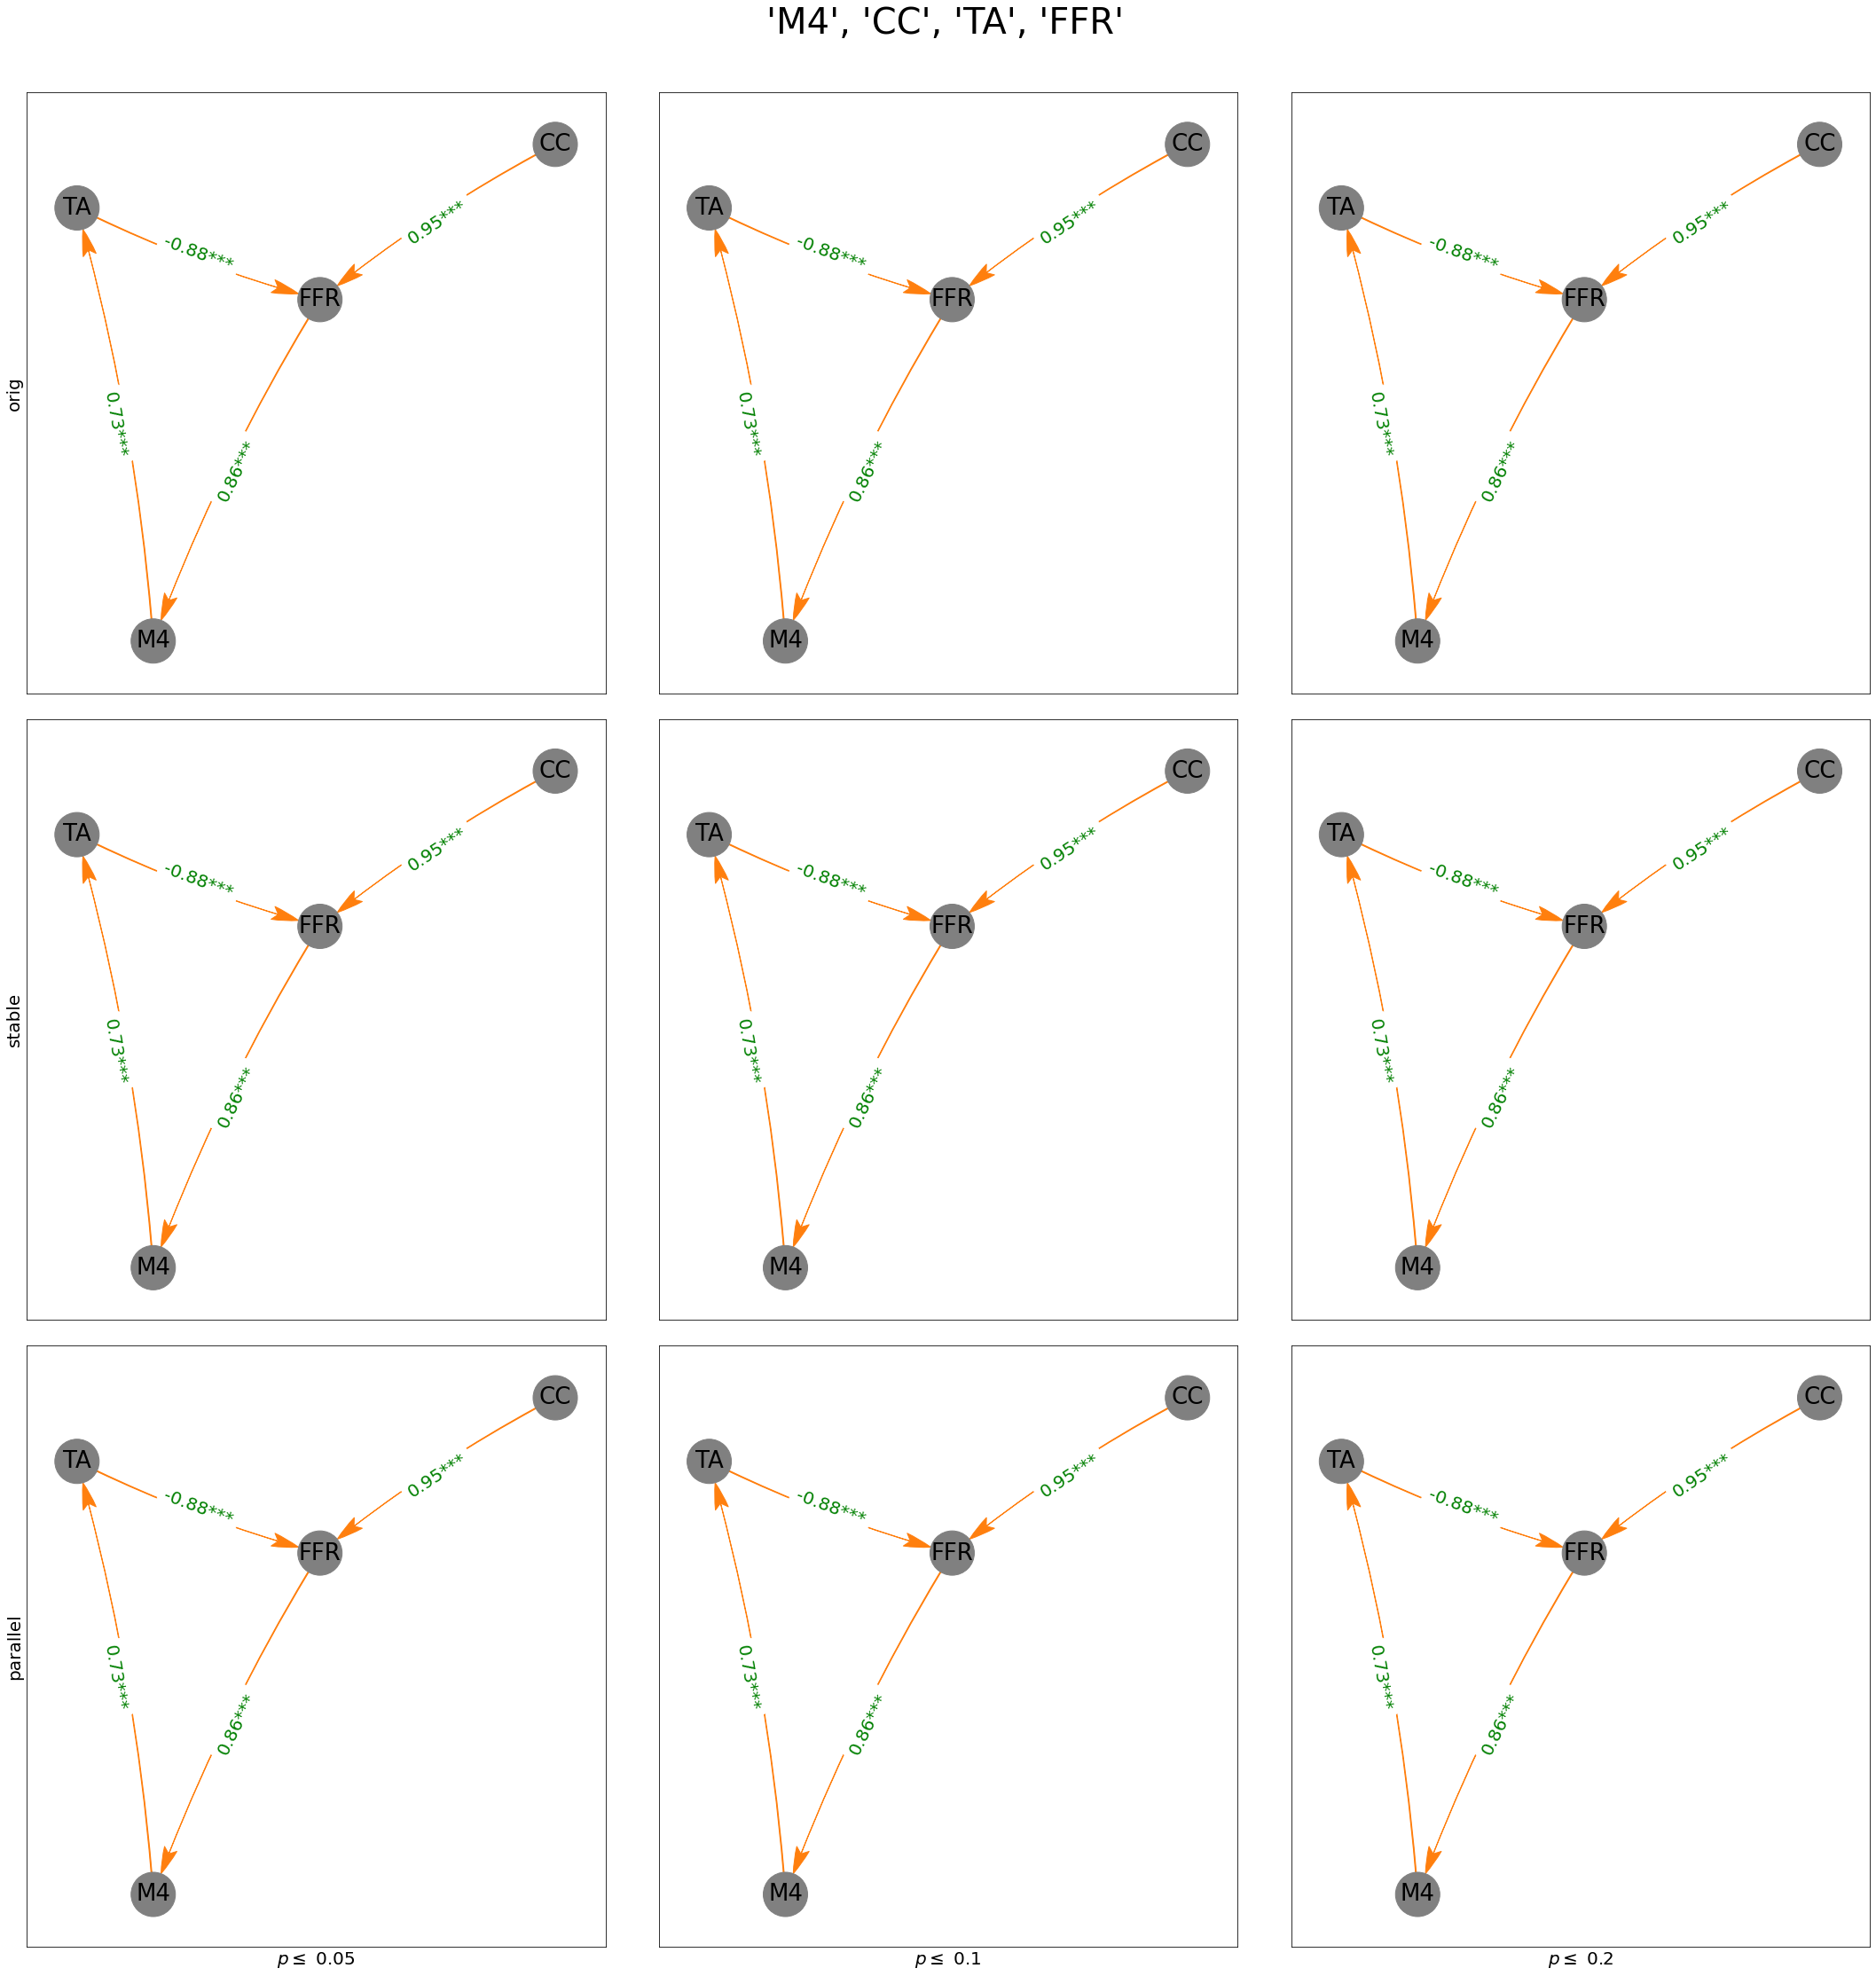

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

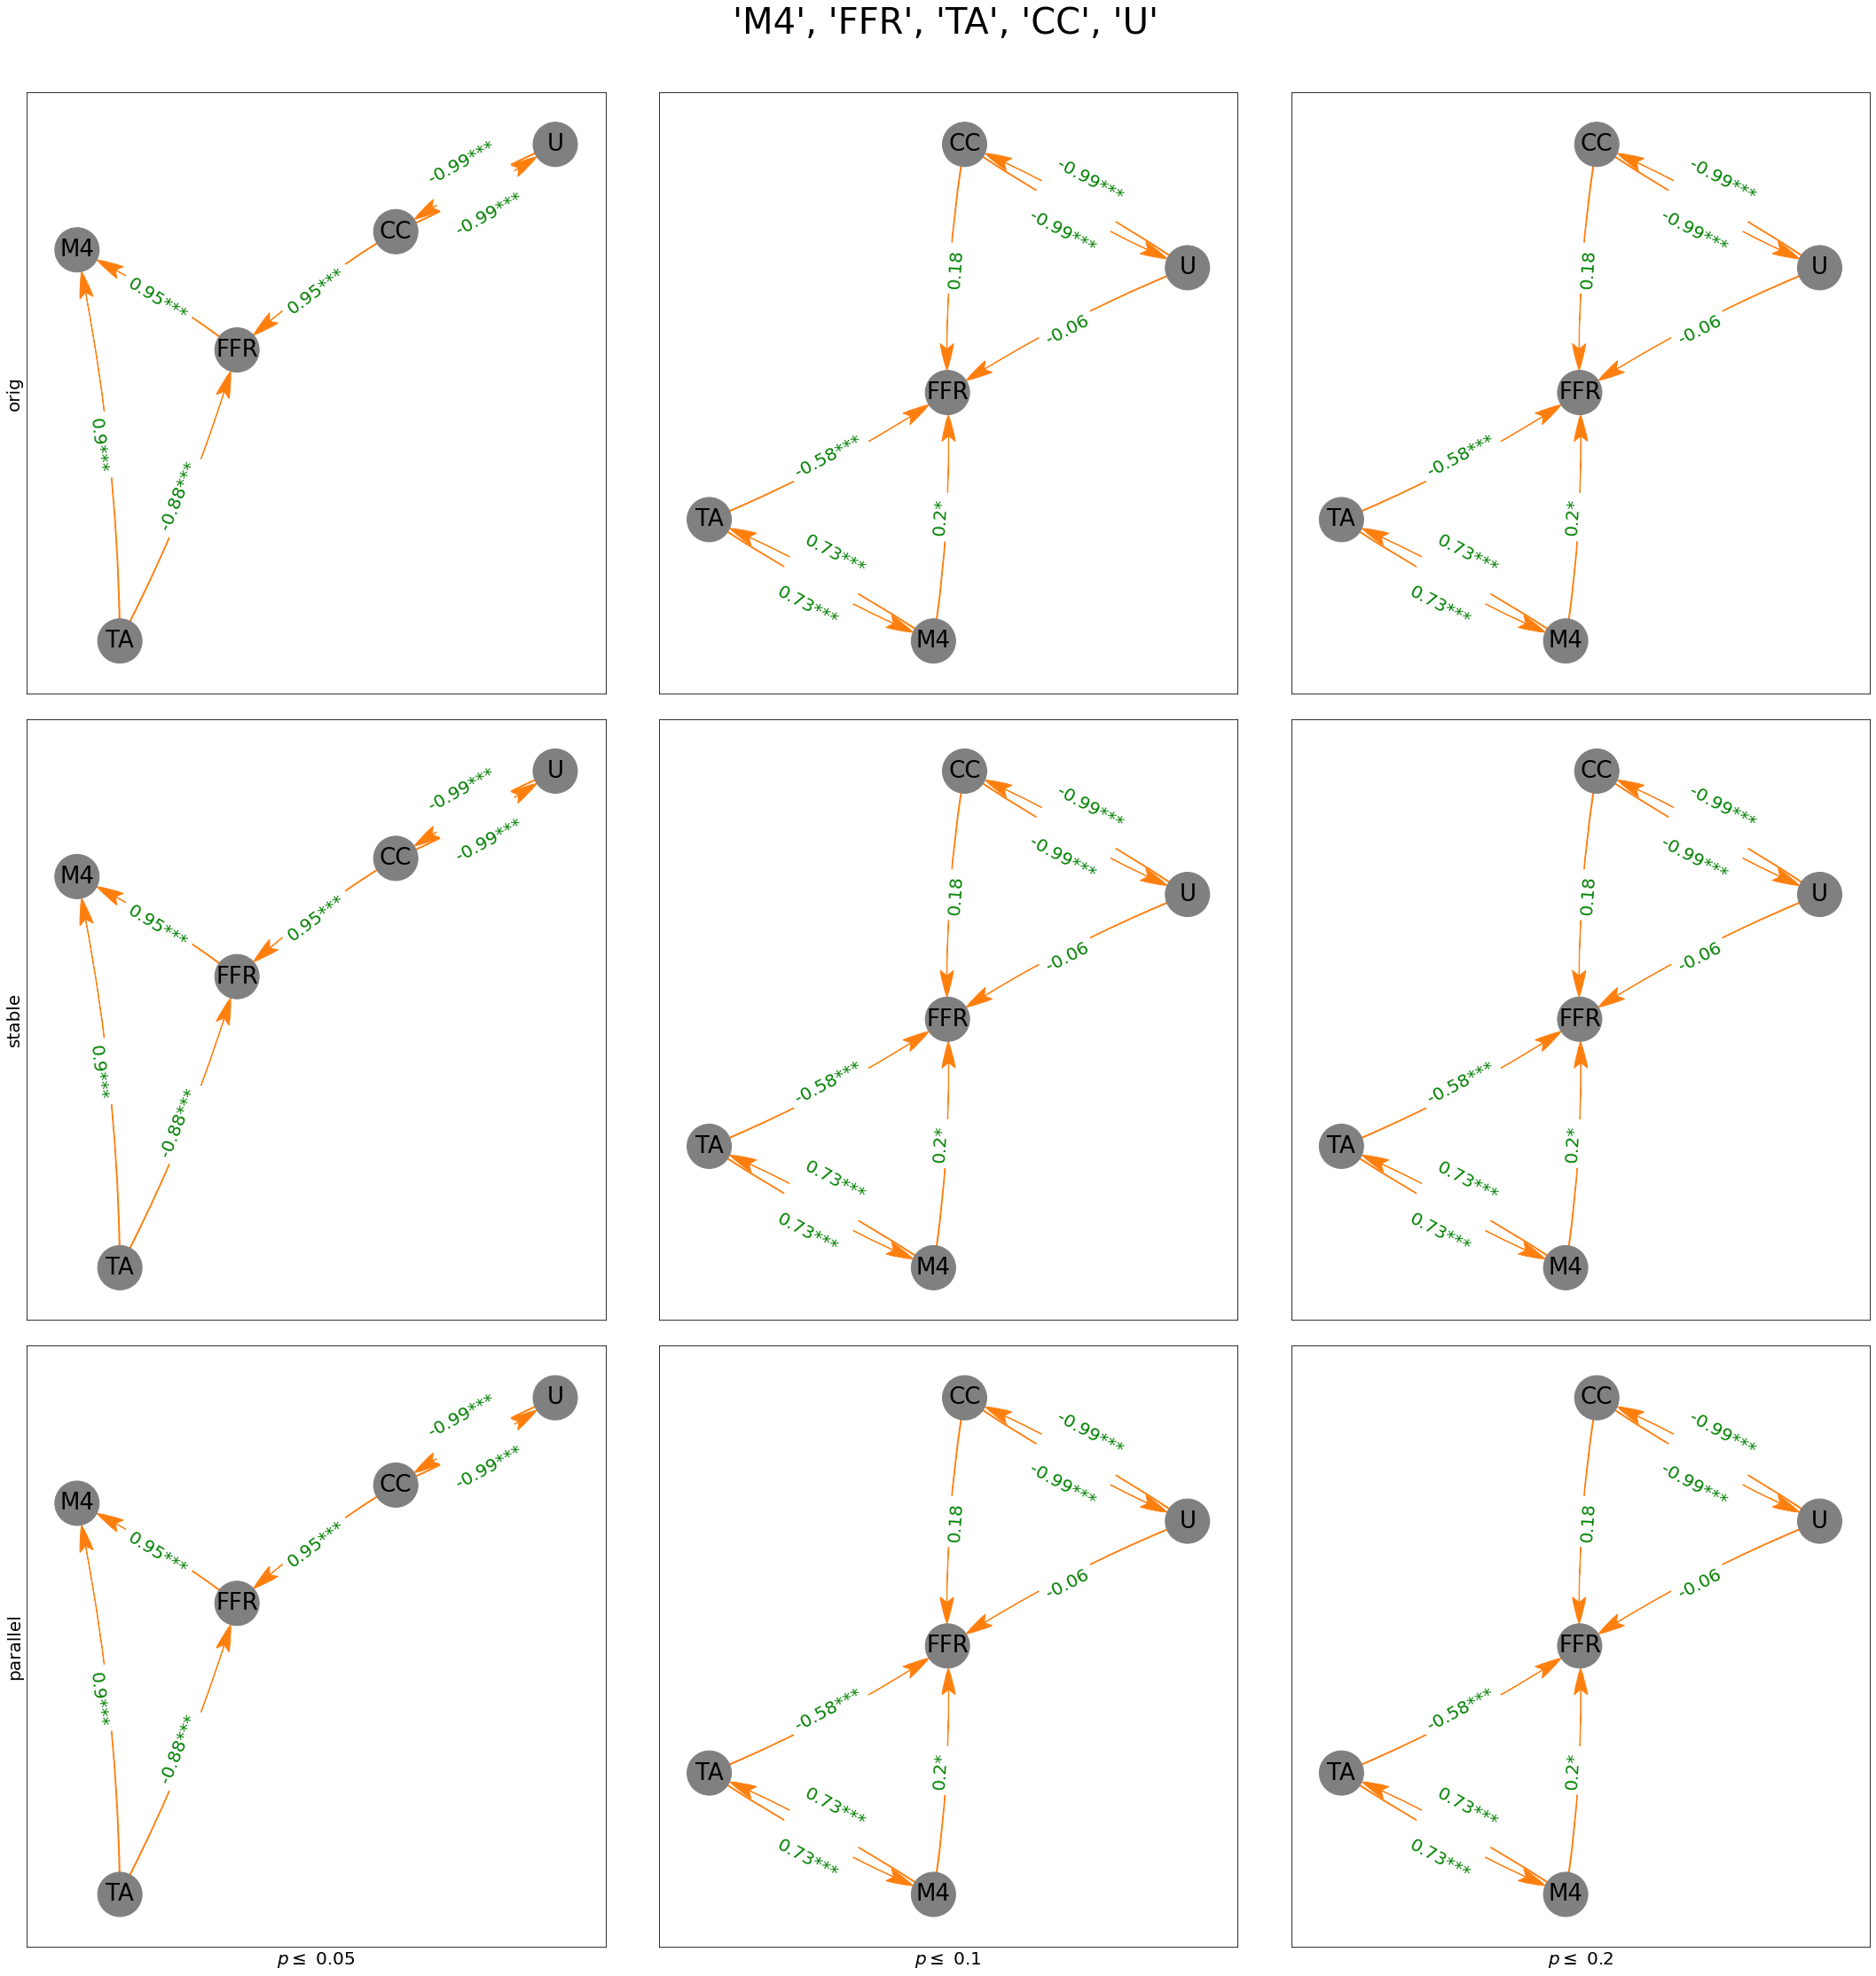

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

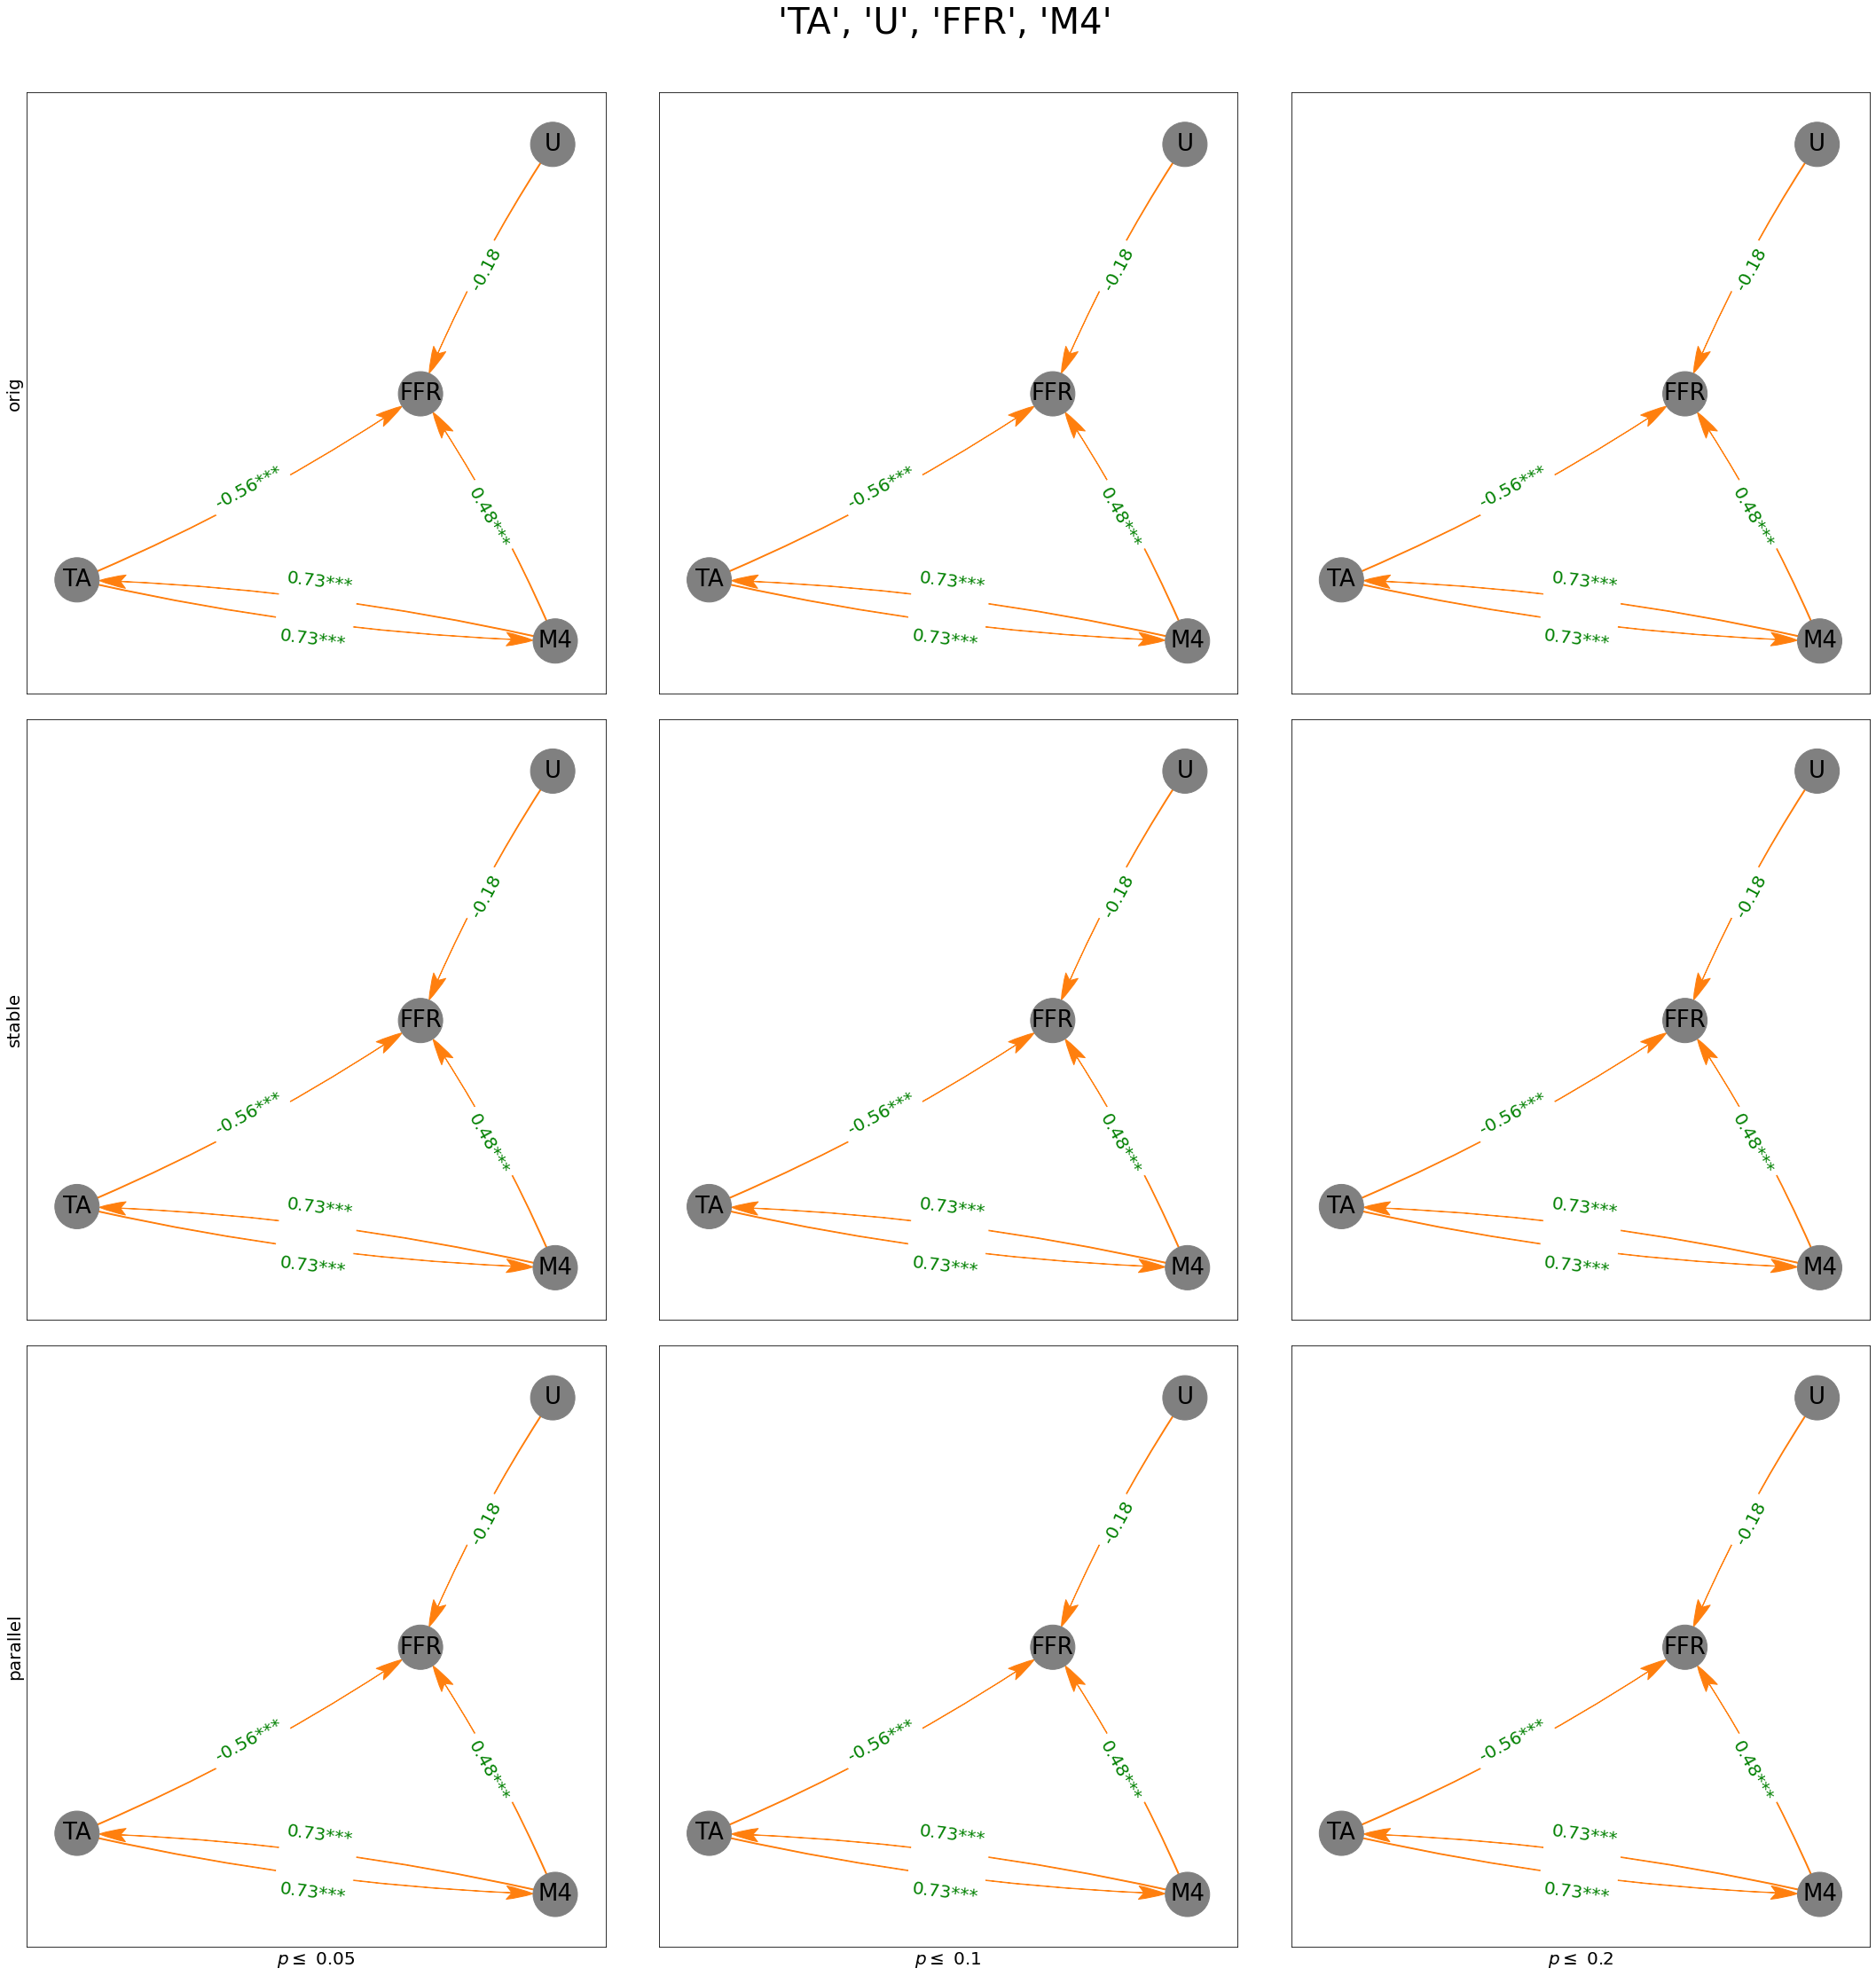

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

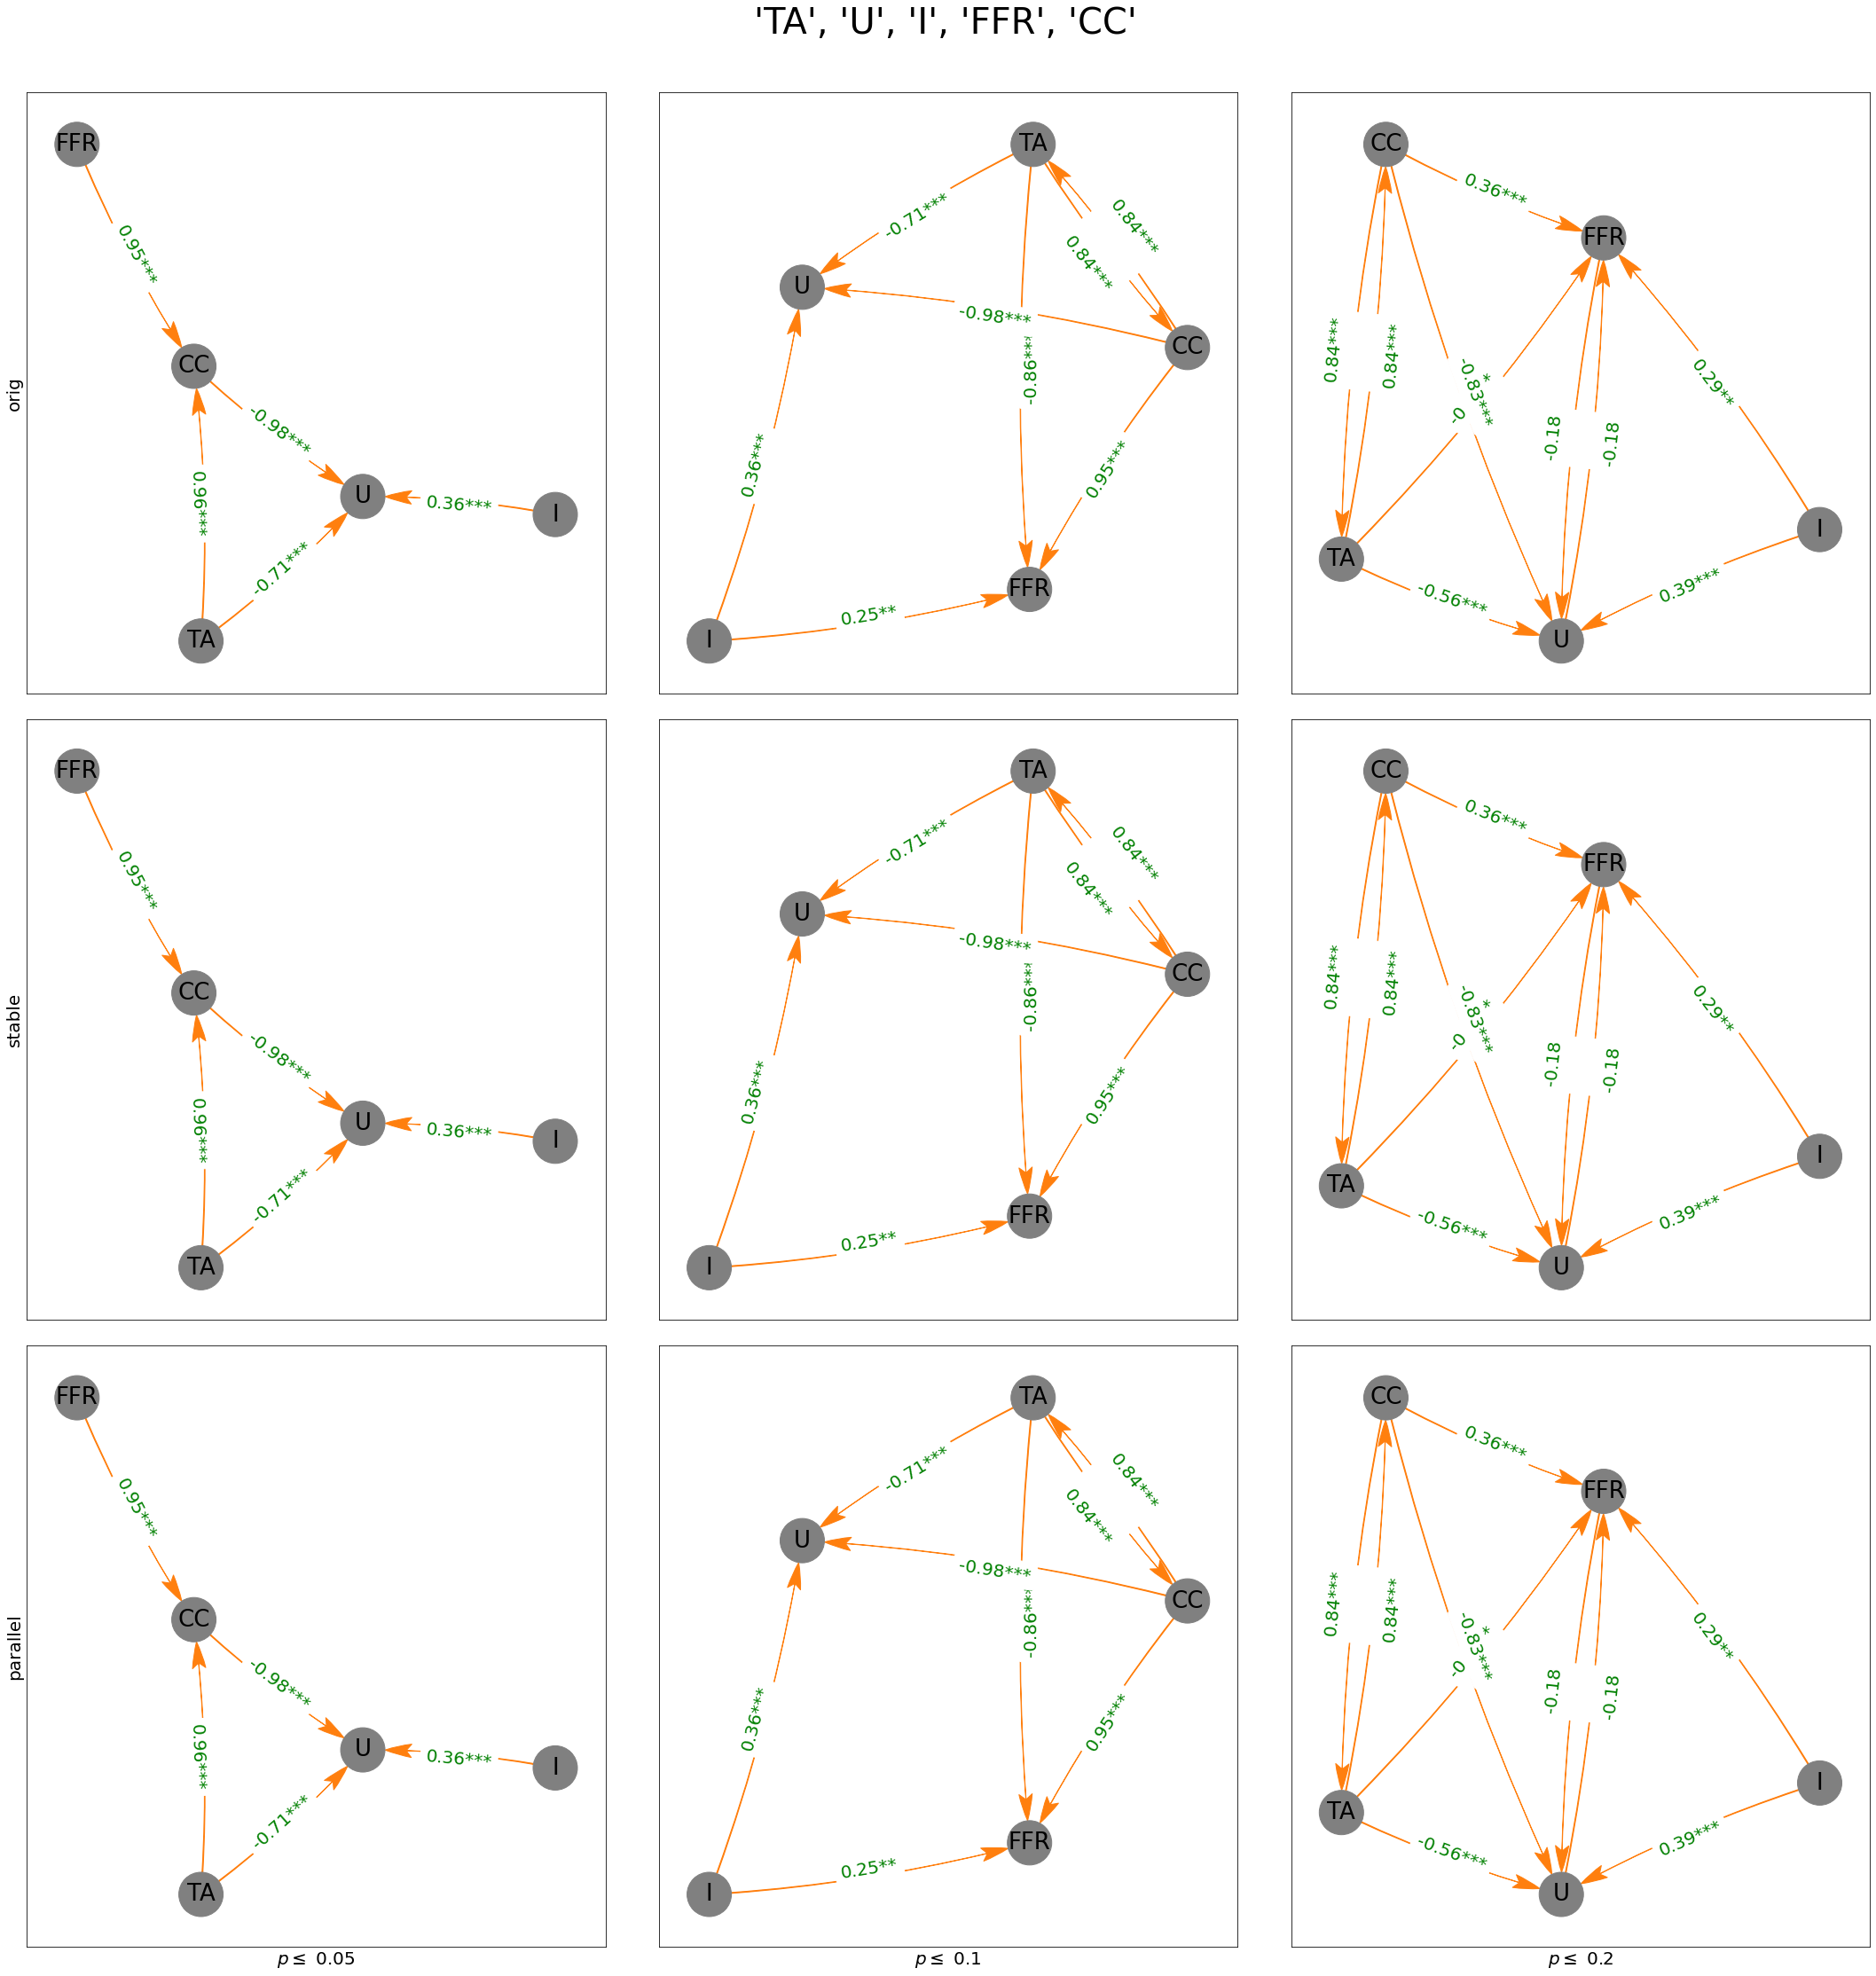

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

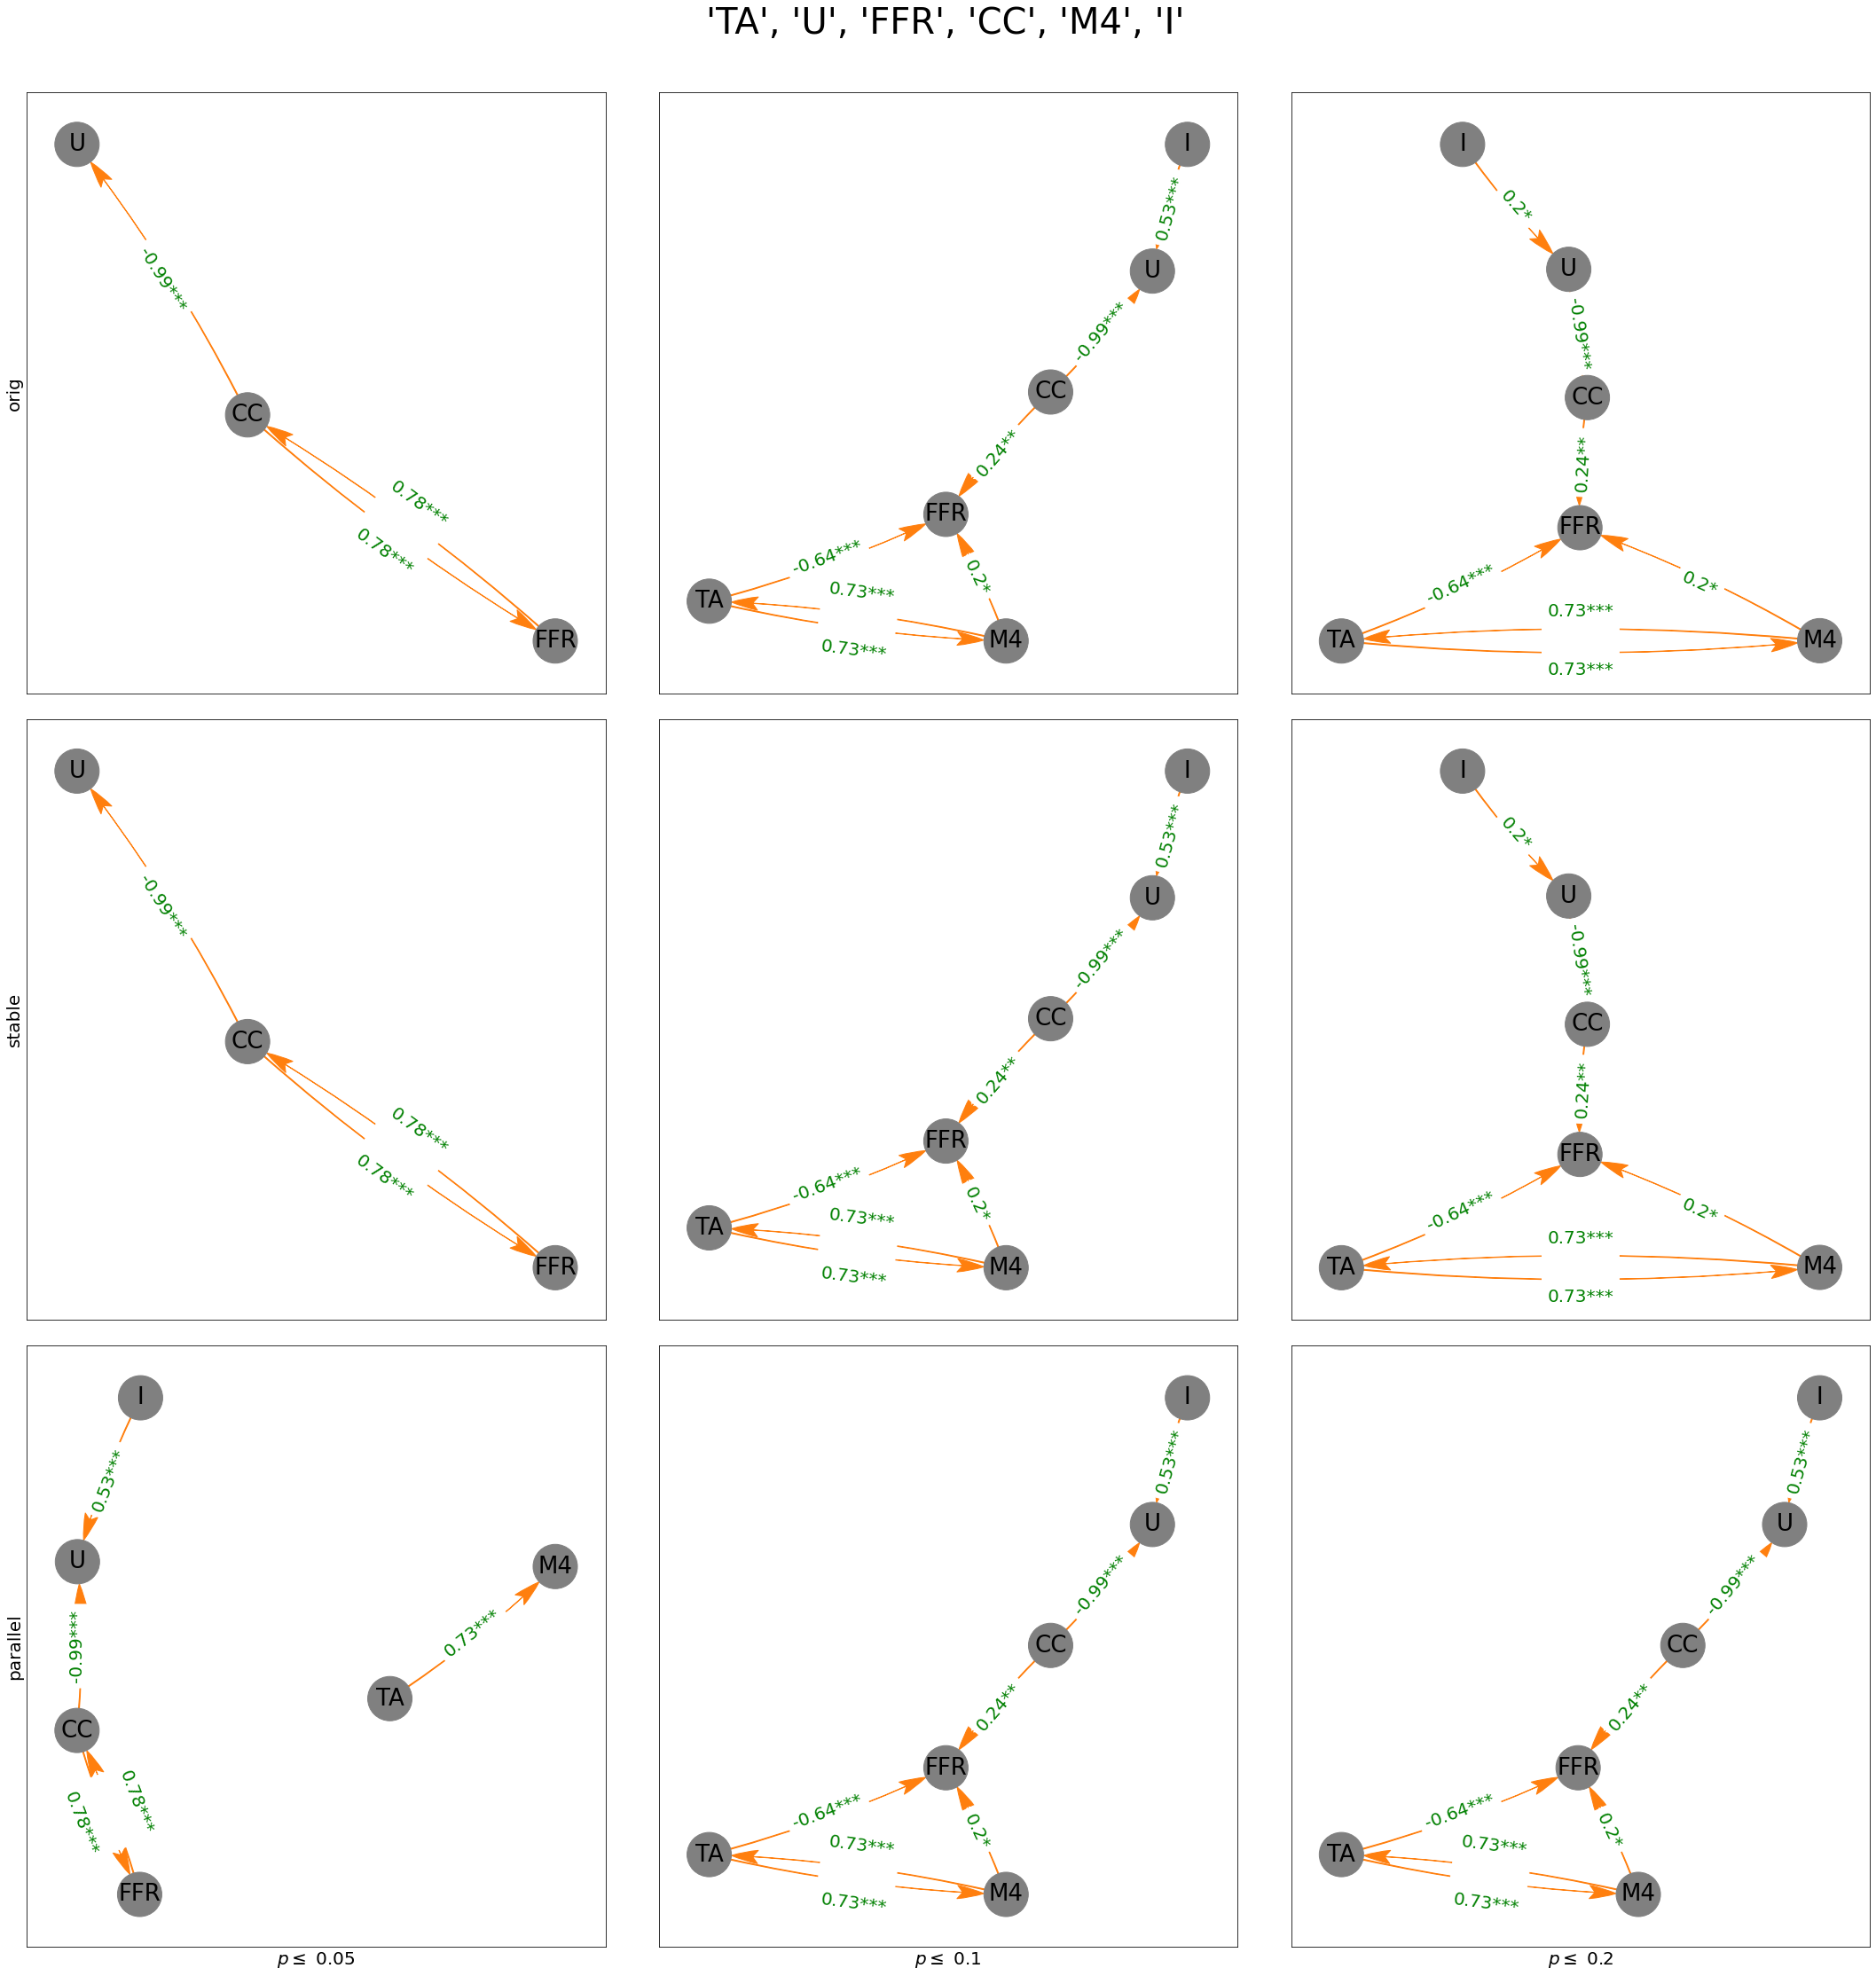

OutEdgeView([('TA', 'FFR'), ('TA', 'M4'), ('CC', 'U'), ('CC', 'FFR'), ('I', 'U'), ('M4', 'FFR'), ('M4', 'TA')])

In [26]:
def graph_DAG(edges, data_reg, title = "", 
              fig = False, ax = False, 
              edge_labels = False,sig_vals = [0.05, 0.01, 0.001]):
    pcorr = data_reg.pcorr()
    graph = nx.DiGraph()
    def build_edge_labels(edges, df, sig_vals):
        edge_labels = {}
        for edge in edges:
            controls = [key for key in df.keys() if key not in edge]
            controls = list(set(controls))
            keep_controls = []
            for control in controls:
                control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
                if (control, edge[1]) in control_edges:
                    keep_controls.append(control)                
#             print(edge, keep_controls)
            pcorr = df.partial_corr(x = edge[0], y = edge[1], covar=keep_controls,
                                  method = "pearson")
            label = str(round(pcorr["r"][0],2))
            pvalue = pcorr["p-val"][0]
#             pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#             label = pcorr[edge[0]].loc[edge[1]]

            for sig_val in sig_vals:
                if pvalue < sig_val: 
                    label = label + "*"   
            
            edge_labels[edge] = label
        return edge_labels
    
    if edge_labels == False:
        edge_labels = build_edge_labels(edges, 
                                        data_reg, 
                                        sig_vals=sig_vals) 
    graph.add_edges_from(edges)
    color_map = ["grey" for g in graph]

    if fig == False and ax == False: fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    #pos = nx.spring_layout(graph)
    pos = graphviz_layout(graph)

    edge_labels2 = []
    for u, v, d in graph.edges(data=True):
        if pos[u][0] > pos[v][0]:  
            if (v,u) in edge_labels.keys():
                edge_labels2.append(((u, v,), f'{edge_labels[u,v]}\n\n\n{edge_labels[(v,u)]}'))  
        if (v,u) not in edge_labels.keys():
            edge_labels2.append(((u,v,), f'{edge_labels[(u,v)]}'))
    edge_labels = dict(edge_labels2)

    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 2500,
                     with_labels=True,  arrows=True,
                     font_color = "black",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                     connectionstyle='arc3, rad = 0.05',
                     ax = a)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20,
                                ax = a)
    

DAG_models_vars = {0:["M4", "TA", "U","I"],
                  1:["M4", "CC", "TA","FFR"],
                  2:["M4", "FFR", "TA", "CC", "U"],
                  3:["TA", "U", "FFR", "M4"],
                  4:["TA", "U","I", "FFR", "CC"],
                  5:["TA", "U", "FFR", "CC","M4", "I"],}
# link_sigs = [0.05, 0.1, 0.2]
link_sigs = [0.05, .1, .2]
algorithms = ["orig", "stable", "parallel"]
for keys in DAG_models_vars.values():
    fig, ax = plt.subplots(len(algorithms), len(link_sigs), figsize = (30,30))
    max_cond_vars = len(keys) - 2
    data_reg = data[keys].dropna()
    data_reg.rename(columns = {col:firstLetterWord(col) for col in keys}, inplace = True)
    keys = data_reg.keys()
    c = PC(data_reg[keys].dropna())
    max_cond_vars = len(keys) - 2
    i,j = 0,0
    for sig in link_sigs:
        for algorithm in algorithms:
            model = c.estimate(return_type = "pdag", variant = algorithm, 
                               significance_level = sig, 
                               max_cond_vars = max_cond_vars, ci_test = "pearsonr")
            edges = model.edges()
            pcorr = data_reg.pcorr()
            weights = {}
            a = ax[i][j]
            graph_DAG(edges, data_reg, fig = fig, ax = a)
        
            if j == 0:
                a.set_ylabel(algorithm, fontsize = 20)
            if i == len(algorithms) - 1:
                a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 20)
            i += 1
        j += 1
        i = 0
    plt.suptitle(str(list(keys)).replace("[","").replace("]",""), fontsize = 40, y =1.035)
    plt.show()
    plt.close()
edges